In [ ]:
week 4 ass 1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

In [8]:
import h5py
import numpy as np

def load_dataset():
    # Load training data
    train_dataset = h5py.File('train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # (m_train, 64, 64, 3)
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # (m_train,)
    
    # Load test data
    test_dataset = h5py.File('test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])    # (m_test, 64, 64, 3)
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])    # (m_test,)
    
    # Load the list of classes (b"cat", b"non-cat")
    classes = np.array(test_dataset["list_classes"][:])          # shape: (2,)

    # Reshape label vectors to (1, m)
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [10]:
train_x, train_y, test_x, test_y, classes = load_dataset()
print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)
print("Classes:", classes)


Train X shape: (209, 64, 64, 3)
Train Y shape: (1, 209)
Test X shape: (50, 64, 64, 3)
Test Y shape: (1, 50)
Classes: [b'non-cat' b'cat']


In [12]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [13]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [16]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [17]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [18]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    ### START CODE HERE ###
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s


In [19]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


In [23]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    ### START CODE HERE ###
    w = np.zeros((dim, 1))
    b = 0.0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b


In [25]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


In [26]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = 1 / (1 + np.exp(-(np.dot(w.T, X) + b)))   # sigmoid activation
    cost = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))  # logistic loss
    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m) * np.dot(X, (A - Y).T)
    db = (1/m) * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)  # turns [[17]] into 17
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost


In [27]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


In [28]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the cost every 100 iterations
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    # Return final parameters and gradients
    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs


In [29]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


In [30]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ###
    A = 1 / (1 + np.exp(-(np.dot(w.T, X) + b)))
    ### END CODE HERE ###

    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ###
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
        ### END CODE HERE ###

    assert(Y_prediction.shape == (1, m))

    return Y_prediction


In [31]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


In [32]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model
    """

    ### START CODE HERE ###

    # Step 1: initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    costs = []

    # Step 2: Gradient descent
    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w, b, X_train, Y_train)

        # Retrieve derivatives
        dw = grads["dw"]
        db = grads["db"]

        # Update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost}")

    # Step 3: Retrieve learned parameters
    parameters = {"w": w, "b": b}
    w = parameters["w"]
    b = parameters["b"]

    # Step 4: Predict
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}

    return d


In [33]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.6931471805599453
Cost after iteration 100: 0.5845083636993086
Cost after iteration 200: 0.46694904094655476
Cost after iteration 300: 0.37600686694802077
Cost after iteration 400: 0.3314632893282513
Cost after iteration 500: 0.30327306747438293
Cost after iteration 600: 0.27987958658260487
Cost after iteration 700: 0.2600421369258757
Cost after iteration 800: 0.2429406846779662
Cost after iteration 900: 0.2280042225672606
Cost after iteration 1000: 0.21481951378449635
Cost after iteration 1100: 0.2030781906064498
Cost after iteration 1200: 0.19254427716706862
Cost after iteration 1300: 0.18303333796883503
Cost after iteration 1400: 0.17439859438448874
Cost after iteration 1500: 0.16652139705400332
Cost after iteration 1600: 0.15930451829756614
Cost after iteration 1700: 0.15266732471296504
Cost after iteration 1800: 0.1465422350398234
Cost after iteration 1900: 0.1408720757031016
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "cat" picture.


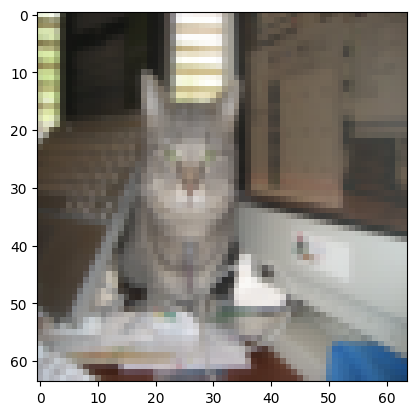

In [34]:
# Example of a picture that was wrongly classified.
index = 7
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

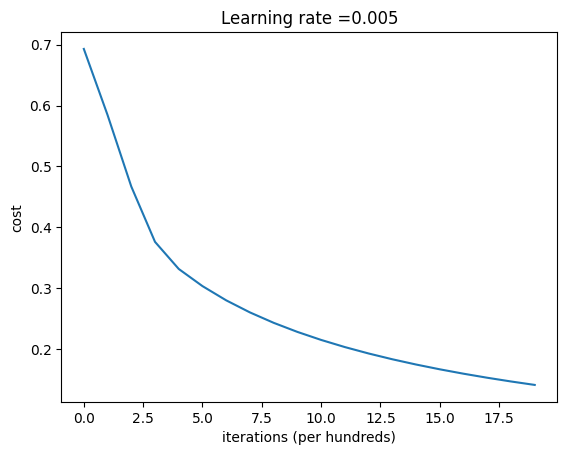

In [35]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



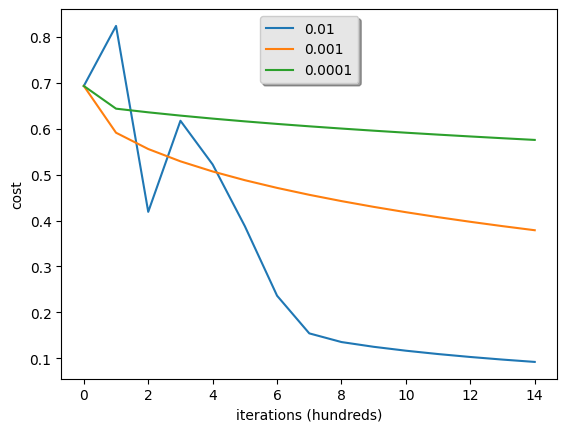

In [36]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [ ]:
week 4 ass 2

In [40]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

In [41]:
X, Y = load_planar_dataset()

In [42]:
X.shape , Y.shape

((2, 400), (1, 400))

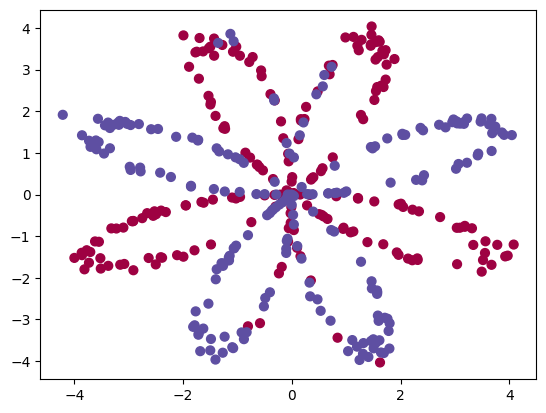

In [43]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [44]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]
### END CODE HERE ###

print('The shape of X is: ' + str(shape_X))
print('The shape of Y is: ' + str(shape_Y))
print('I have m = %d training examples!' % (m))


The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


In [45]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T.ravel());

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


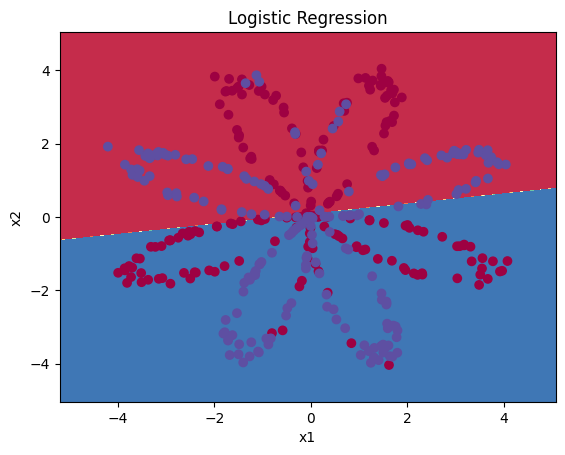

In [46]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.sum(LR_predictions == Y.ravel()))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

In [47]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer (we choose a fixed size)
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0]       # number of input features
    n_h = 4                # number of hidden units (you can choose other values like 5, 10, etc.)
    n_y = Y.shape[0]       # number of output units
    ### END CODE HERE ###
    
    return (n_x, n_h, n_y)


In [48]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


In [49]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    parameters -- python dictionary containing your parameters:
                  W1 -- weight matrix of shape (n_h, n_x)
                  b1 -- bias vector of shape (n_h, 1)
                  W2 -- weight matrix of shape (n_y, n_h)
                  b2 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(2)  # ensure reproducibility

    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    ### END CODE HERE ###

    # Sanity checks
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    # Return parameters dictionary
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


In [50]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


In [51]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve parameters
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###

    # Forward propagation
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)              # Hidden layer activation
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))    # Sigmoid activation for binary classification
    ### END CODE HERE ###

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache


In [52]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


In [53]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost

    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2 (not used here)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]  # number of examples

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), (1 - Y))
    cost = - np.sum(logprobs) / m
    ### END CODE HERE ###
    
    cost = float(np.squeeze(cost))  # E.g., turns [[17]] into 17
    assert(isinstance(cost, float))

    return cost


In [54]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6930587610394646


In [55]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation
    
    Arguments:
    parameters -- python dictionary containing parameters
    cache -- dictionary containing "Z1", "A1", "Z2", and "A2"
    X -- input data of shape (n_x, m)
    Y -- true "label" vector of shape (1, m)

    Returns:
    grads -- dictionary with gradients w.r.t parameters
    """
    m = X.shape[1]

    # Retrieve W1 and W2
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    # Retrieve A1 and A2
    A1 = cache["A1"]
    A2 = cache["A2"]

    # Backpropagation
    dZ2 = A2 - Y                                 # (1, m)
    dW2 = (1 / m) * np.dot(dZ2, A1.T)            # (1, m) x (m, n_h) => (1, n_h)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)  # (1, 1)

    dZ1 = np.dot(W2.T, dZ2) * (1 - A1 ** 2)       # (n_h, m)
    dW1 = (1 / m) * np.dot(dZ1, X.T)              # (n_h, m) x (m, n_x) => (n_h, n_x)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)  # (n_h, 1)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads


In [56]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


In [57]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule
    
    Arguments:
    parameters -- python dictionary containing parameters 
    grads -- python dictionary containing gradients 
    learning_rate -- learning rate for gradient descent

    Returns:
    parameters -- python dictionary with updated parameters
    """

    # Retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Retrieve gradients
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # Gradient descent update
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


In [58]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


In [59]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model
    """

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation
        A2, cache = forward_propagation(X, parameters)

        # Compute cost
        cost = compute_cost(A2, Y, parameters)

        # Backward propagation
        grads = backward_propagation(parameters, cache, X, Y)

        # Update parameters
        parameters = update_parameters(parameters, grads)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    return parameters


In [60]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]


In [61]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your trained parameters 
    X -- input data of size (n_x, m)
    
    Returns:
    predictions -- vector of predictions of the model (0 or 1)
    """
    
    # Forward propagation to get predicted probabilities
    A2, cache = forward_propagation(X, parameters)

    # Convert probabilities to binary predictions (0 or 1)
    predictions = (A2 > 0.5).astype(int)

    return predictions


In [62]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219490
Cost after iteration 9000: 0.218617


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

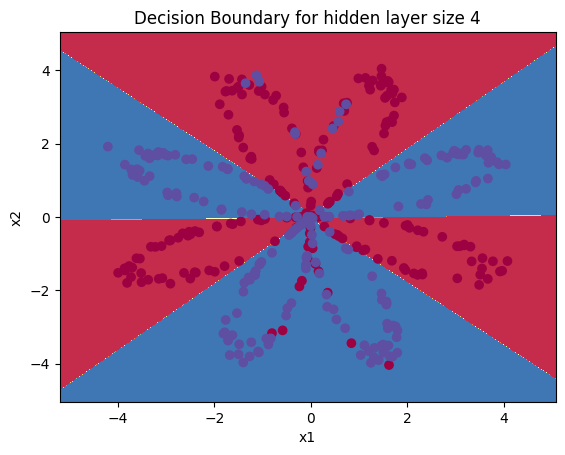

In [63]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [64]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.sum(predictions == Y.ravel()))/float(Y.size)*100) + '%')

Accuracy: 90%


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.75 %


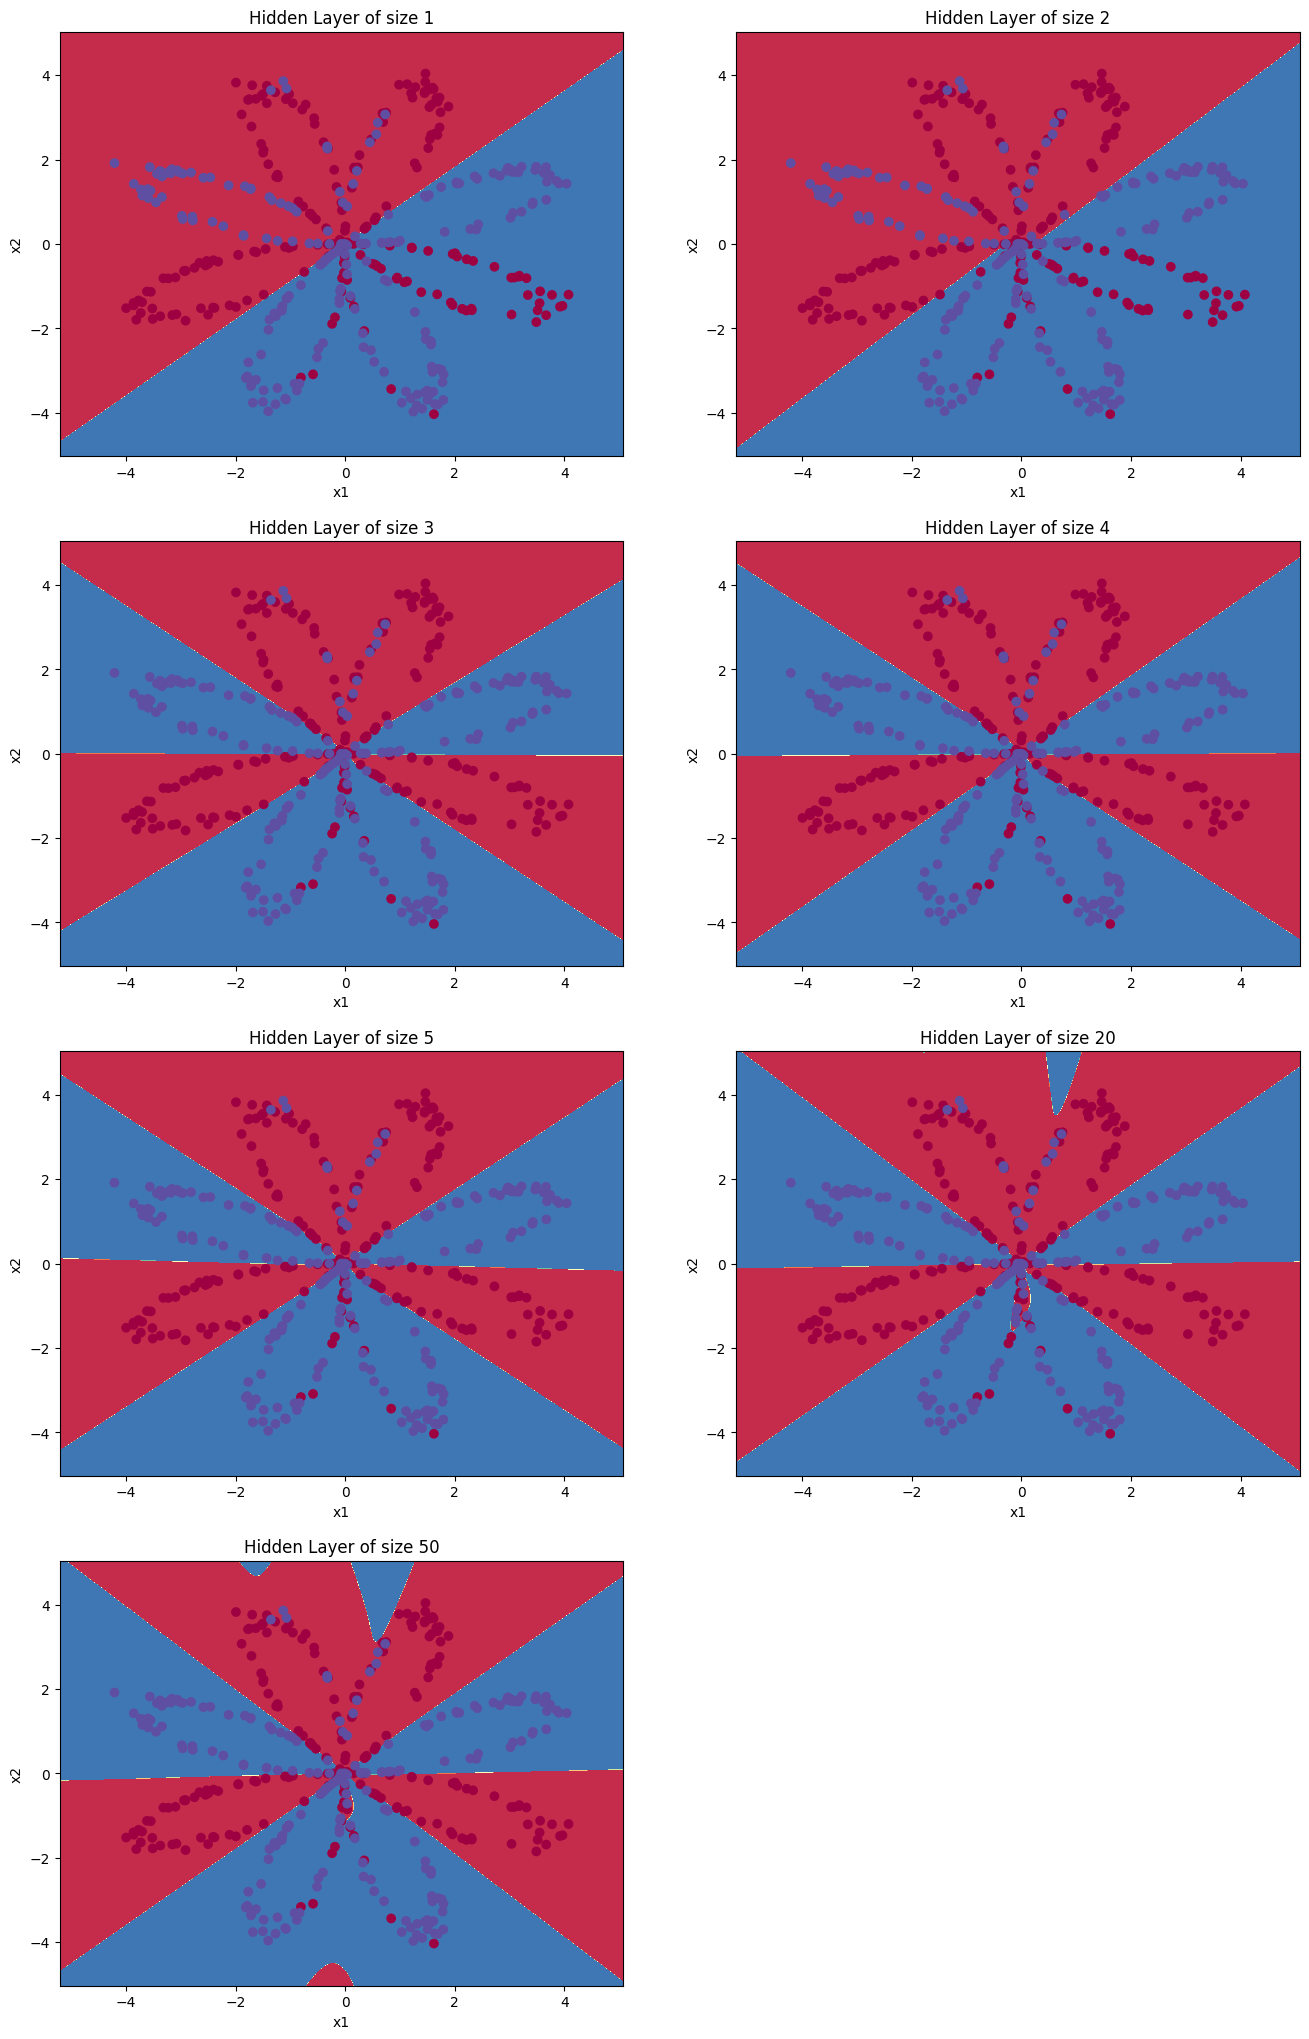

In [65]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.sum(predictions == Y.ravel()))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

In [ ]:
week4 ass3 

In [66]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases_v4a import *
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

np.random.seed(1)

In [67]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    ### START CODE HERE ###
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    ### END CODE HERE ###
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


In [68]:
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]


In [69]:
# GRADED FUNCTION: initialize_parameters_deep

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python list containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                  Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                  bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ###
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


In [70]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[0.]
 [0.]
 [0.]]


In [71]:
# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    ### START CODE HERE ###
    Z = np.dot(W, A) + b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache


In [72]:
A, W, b = linear_forward_test_case()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


In [73]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function
    cache -- a tuple containing "linear_cache" and "activation_cache";
             used for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Linear step
        Z, linear_cache = linear_forward(A_prev, W, b)
        # Activation step
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Linear step
        Z, linear_cache = linear_forward(A_prev, W, b)
        # Activation step
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


In [74]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


In [75]:
# GRADED FUNCTION: L_model_forward

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network

    # Implement [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, 
            parameters['W' + str(l)], 
            parameters['b' + str(l)], 
            activation='relu'
        )
        caches.append(cache)

    # Implement LINEAR -> SIGMOID for the final layer
    AL, cache = linear_activation_forward(
        A, 
        parameters['W' + str(L)], 
        parameters['b' + str(L)], 
        activation='sigmoid'
    )
    caches.append(cache)

    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches


In [76]:
X, parameters = L_model_forward_test_case_2hidden()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
Length of caches list = 3


In [77]:
# GRADED FUNCTION: compute_cost

def compute_cost(AL, Y):
    """
    Implement the cross-entropy cost function.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute the cross-entropy loss
    cost = -1/m * np.sum(Y * np.log(AL + 1e-8) + (1 - Y) * np.log(1 - AL + 1e-8))
    # The 1e-8 is added for numerical stability to avoid log(0)

    cost = np.squeeze(cost)  # Ensure cost is a scalar
    assert(cost.shape == ())

    return cost


In [78]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.2797765501534163


In [79]:
# GRADED FUNCTION: linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) from forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


In [80]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db = [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]


In [81]:
# GRADED FUNCTION: linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) 
    activation -- "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient w.r.t. the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient w.r.t. W (current layer l), same shape as W
    db -- Gradient w.r.t. b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = np.array(dA, copy=True)  # just converting dA to a correct object.
        dZ[activation_cache <= 0] = 0
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        Z = activation_cache
        s = 1 / (1 + np.exp(-Z))
        dZ = dA * s * (1 - s)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


In [82]:
dAL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


In [83]:
# GRADED FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches from linear_activation_forward() for each layer
    
    Returns:
    grads -- A dictionary with gradients:
             grads["dA" + str(l)], grads["dW" + str(l)], grads["db" + str(l)]
    """
    grads = {}
    L = len(caches)  # number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # make sure shapes match

    # Initializing the backpropagation
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # derivative of cost w.r.t AL

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L - 1]
    dA_prev, dW, db = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    grads["dA" + str(L - 1)] = dA_prev
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db

    # Loop from l = L-2 to 0
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    return grads


In [84]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print_grads(grads)

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


In [85]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter
    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]
    
    return parameters


In [86]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


In [ ]:
week 4 ass 4

In [88]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


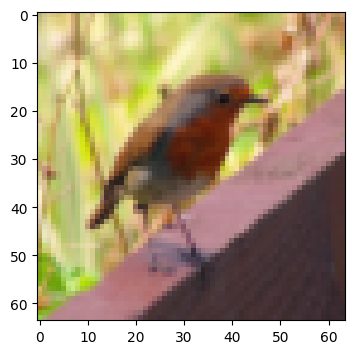

In [91]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [92]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [93]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [94]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [95]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              
    m = X.shape[1]                           
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters
    ### START CODE HERE ###
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Gradient Descent loop
    for i in range(0, num_iterations):

        # Forward propagation
        ### START CODE HERE ###
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ###
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        ### START CODE HERE ###
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        ### END CODE HERE ###
        
        # Store gradients
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters
        ### START CODE HERE ###
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve updated parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
      
        # Track cost
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
    
    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203889
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614832
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.1744831811255665
Cost after iteration 1600: 0.1708076297809593
Cost after iteration 1700: 0.11306524562164734
Cost after iteration 1800: 0.09629426845937145
Cost after iteration 1900: 0.08342617959726863
Cost after iteration 2000: 0.07439078704319081
Cost after iteration 2100: 0.06630748132

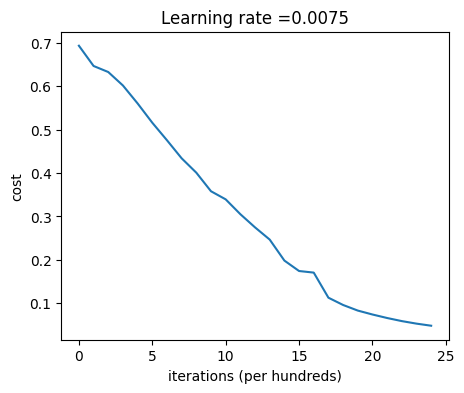

In [96]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [97]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [98]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [99]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [100]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    """
    
    costs = []                             
    m = X.shape[1]
    
    # Parameters initialization
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Gradient descent
    for i in range(0, num_iterations):
        
        # Forward propagation
        ### START CODE HERE ###
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ###
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
        
        # Backward propagation
        ### START CODE HERE ###
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
        
        # Update parameters
        ### START CODE HERE ###
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
        
        # Print cost
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters


Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6777810383614872
Cost after iteration 200: 0.6616061016114193
Cost after iteration 300: 0.6390795424014046
Cost after iteration 400: 0.6140081332503392
Cost after iteration 500: 0.5853416119947714
Cost after iteration 600: 0.5625706606448345
Cost after iteration 700: 0.5148169504209336
Cost after iteration 800: 0.4652980579925056
Cost after iteration 900: 0.43227230252959725
Cost after iteration 1000: 0.4122795893544487
Cost after iteration 1100: 0.3549445550382375
Cost after iteration 1200: 0.3177251921065039
Cost after iteration 1300: 0.2916517247174061
Cost after iteration 1400: 0.27159095513726583
Cost after iteration 1500: 0.24620453180863483
Cost after iteration 1600: 0.23008973256658308
Cost after iteration 1700: 0.20715593358302803
Cost after iteration 1800: 0.19378092995686425
Cost after iteration 1900: 0.19597930533523167
Cost after iteration 2000: 0.172804556137004
Cost after iteration 2100: 0.16293228162

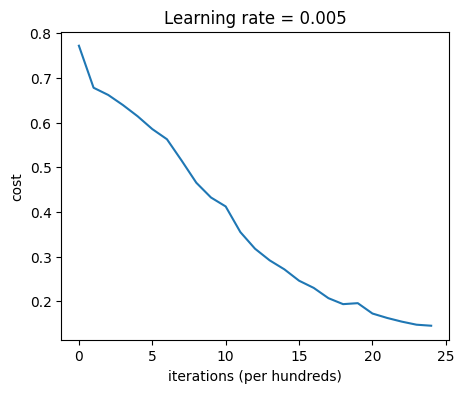

In [101]:
parameters = L_layer_model(train_x, train_y, layers_dims,learning_rate=0.005, num_iterations = 2500, print_cost = True)

In [102]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [103]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.76


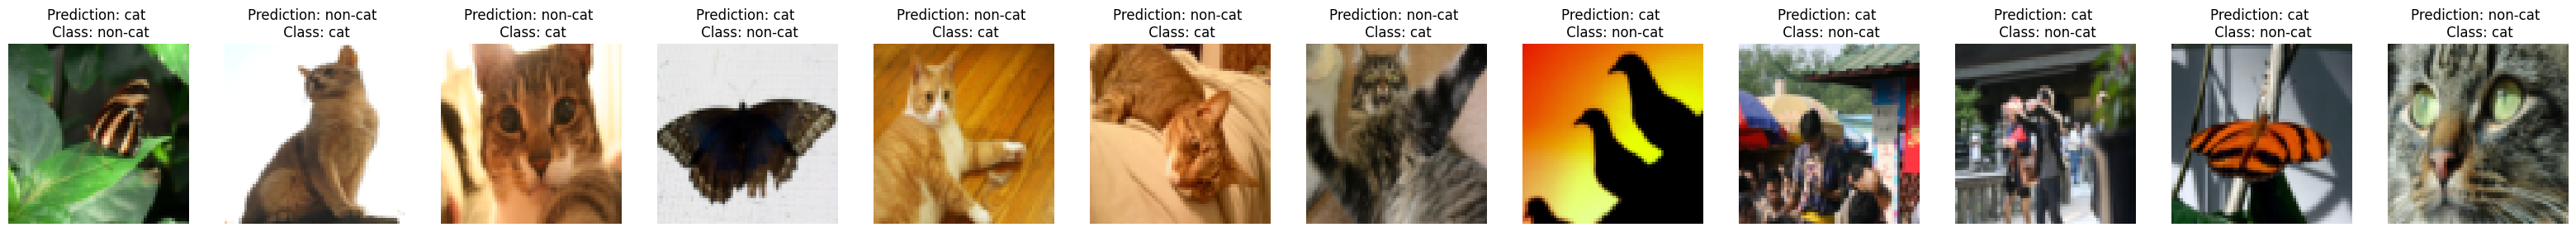

In [104]:
print_mislabeled_images(classes, test_x, test_y, pred_test)